In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

from helper.lorenz import solve_lorenz
from helper.reservoir import  run_reservoir
from helper.visualization import plot_lorenz_attractor, plot_prediction_comparison
from helper.analysis import compare_predictions, plot_mse, analyze_prediction
from helper.hyperparameter_tuning import grid_search_tuning, grid_search_OTSE, run_model_func, mse_scoring_func
from helper.one_step_error import compute_one_step_error
from dhruvit_lorenz import get_lorenz


### Lorenz Data Fixed

First point of x, y, z
[-4.94927582 -4.23333949 19.51434926]
Last point of x, y, z
[-7.46171931 -7.41392905 21.04898162]


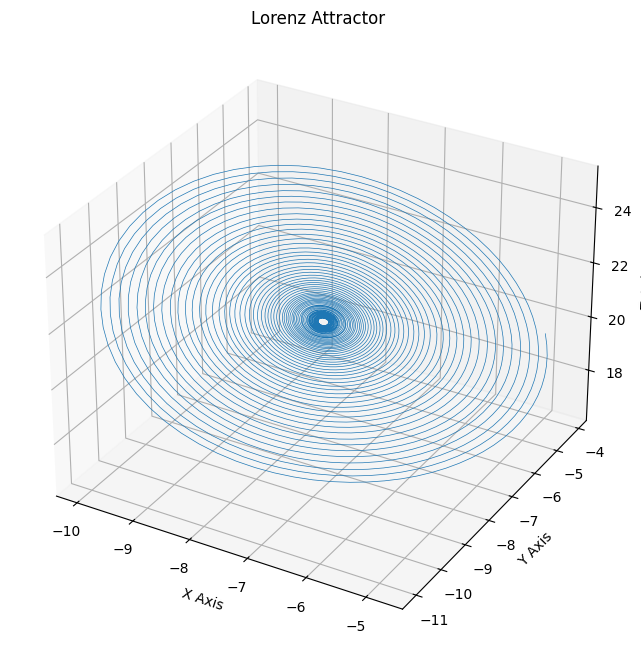

In [3]:
ls = {
    'dt':    0.01,
    't1':    0.0,
    'trans': 5.0,
    't2':    50.0,
    'beta':  8/3,
    'sigma': 10.0,
    'eps':   [0.001, 0.001, 0.001],
}

# constant-ρ series at 28.0
rho_series = np.full(int((ls['t2']-ls['t1'])/ls['dt'])+1, 22.0)
v0 = [1.0, 1.0, 1.0]

t, v = get_lorenz(ls, rho_series, v0)
# then v[0], v[1], v[2], v[3] are x, y, z, rho respectively
print("First point of x, y, z")
print(v[:-1].T[0])

print("Last point of x, y, z")
print(v[:-1].T[-1])

data = v[:-1].T

plot_lorenz_attractor(data, verbose=False)

[-5.03509041 -4.28481932 19.6622633 ]
[-7.28062169 -7.12460326 21.00471102]


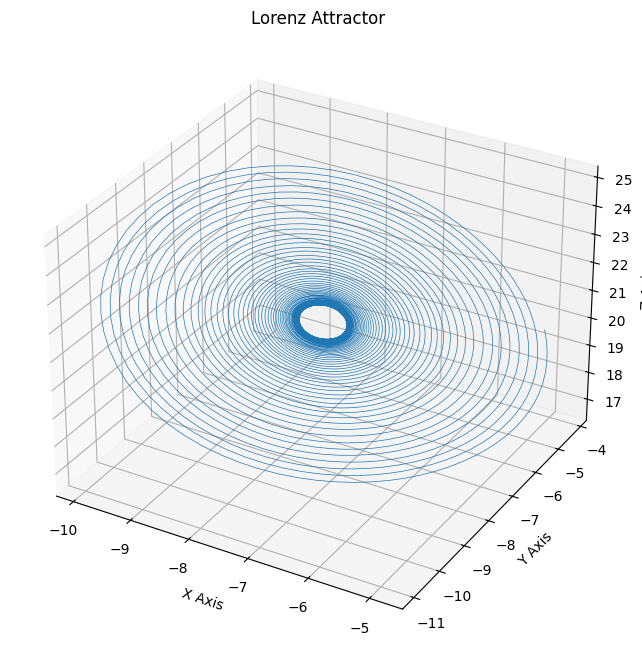

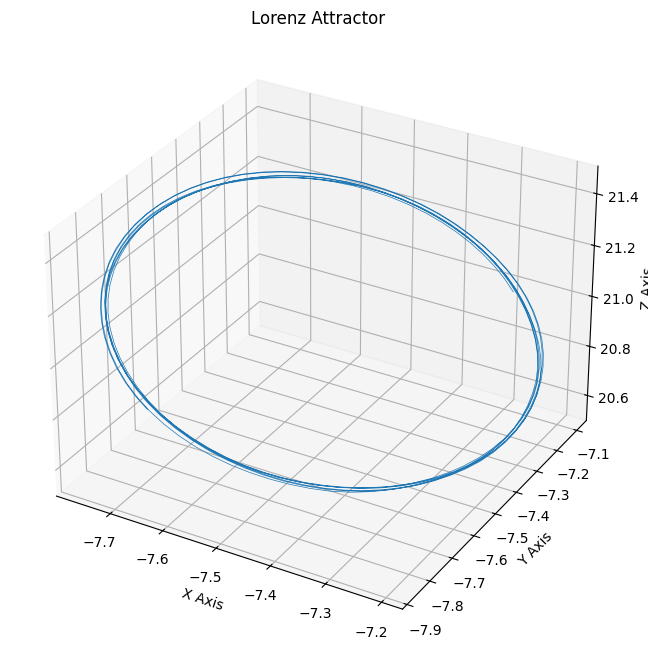

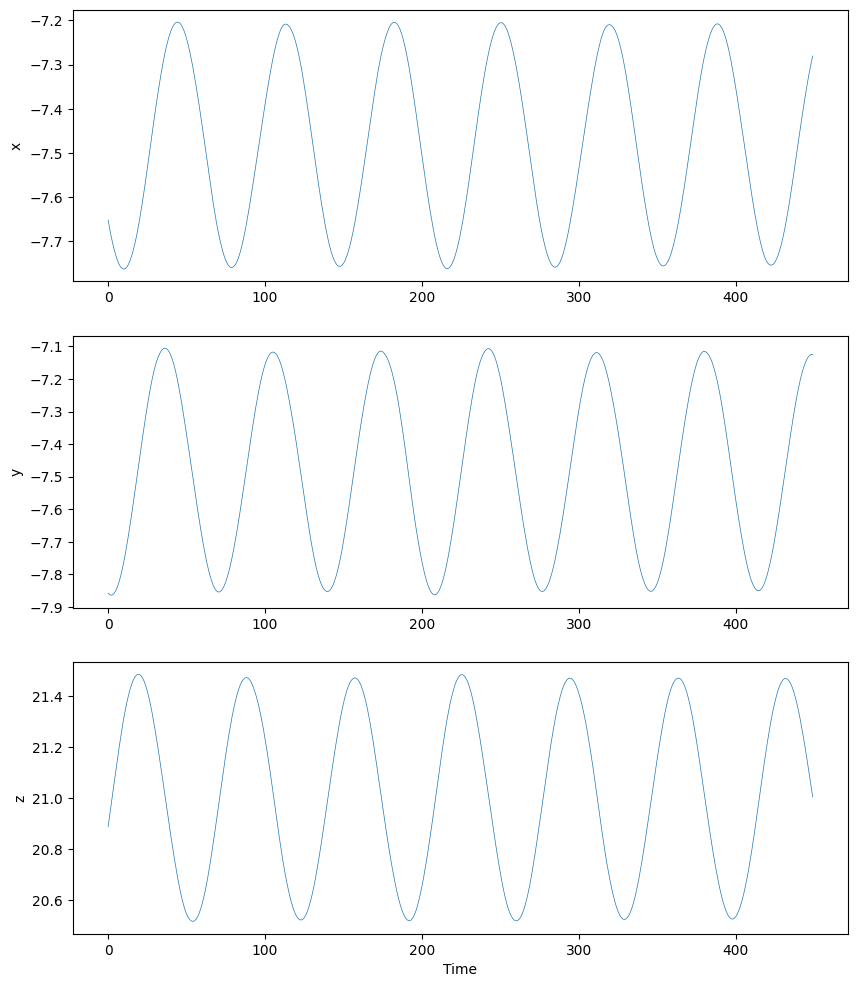

In [4]:
# Generate data
x0 = [1,1,1]
t_start = 0
t_end = 50
t_eval = .01
t_span = (0,t_end)

train_test_split = .9

data = solve_lorenz(t_end=t_end, t_eval=t_eval, initial_state=x0, rho=22)
# data = solve_lorenz(t_end=t_end, t_eval=t_eval, initial_state=x0)

data = data[500:]
print(data[0])
print(data[-1])


plot_lorenz_attractor(data, verbose=False)

# Split data
split_idx = int((t_end - t_start - 5) / t_eval * train_test_split)
train_data = data[:split_idx]
test_data = data[split_idx:]

plot_lorenz_attractor(test_data)

### Priliminary Exp

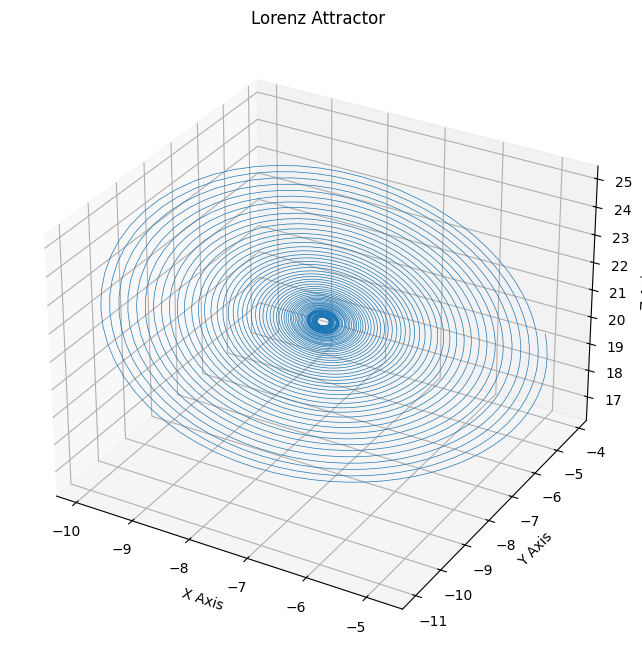

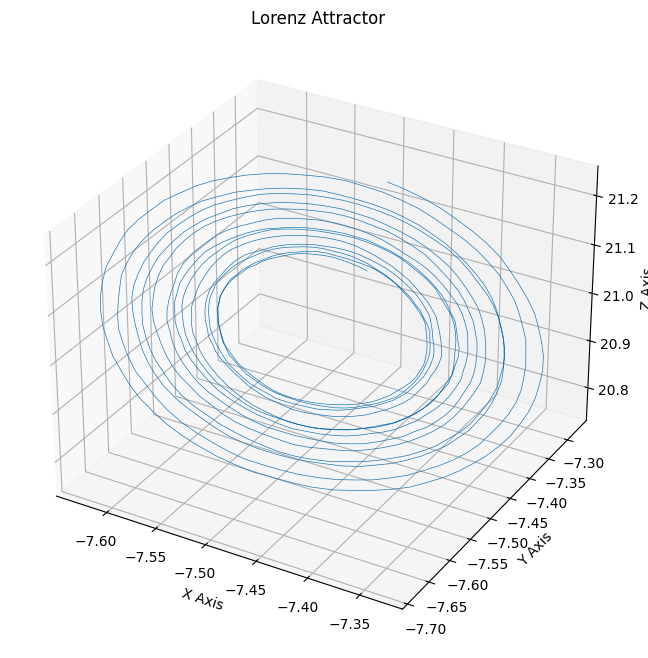

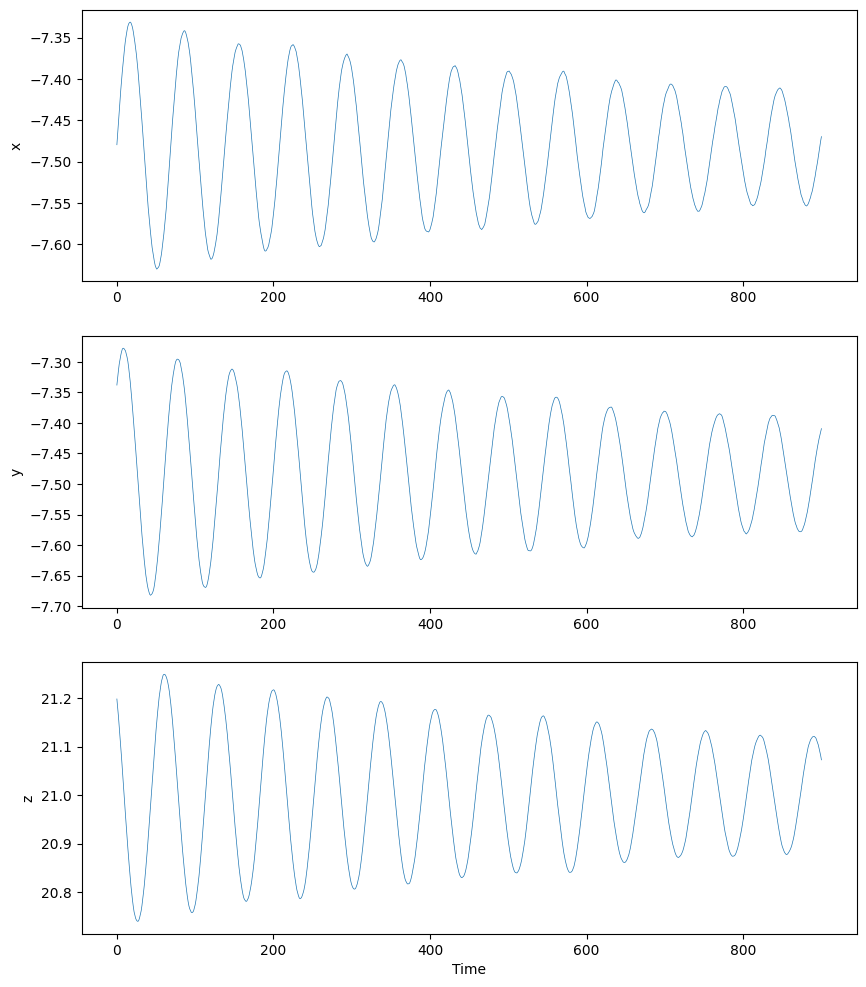

In [5]:
t_start = 0
t_end = 50
t_trans = 5
t_eval = .01

ls = {
    'dt':    t_eval,
    't1':    t_start,
    'trans': t_trans,
    't2':    t_end,
    'beta':  8/3,
    'sigma': 10.0,
    'eps':   [0.001, 0.001, 0.001],
}

# constant-ρ series at 28.0
rho_series = np.full(int((ls['t2']-ls['t1'])/ls['dt'])+1, 22.0)
v0 = [1.0, 1.0, 1.0]

t, v = get_lorenz(ls, rho_series, v0)
data = v[:-1].T

train_test_split = .8

plot_lorenz_attractor(data, verbose=False)

# Split data
split_idx = int((t_end - t_start - t_trans) / t_eval * train_test_split)
train_data = data[:split_idx]
test_data = data[split_idx:]

plot_lorenz_attractor(test_data)

In [5]:
# Use the function for both cases 
# Original reservoir 
result_original = run_reservoir(train_data, test_data)
predictions = result_original['predictions']

# Zero adjacency matrix reservoir
reservoir_params = {
        'output_dim': 3,
        'reservoir_dim': 300,
        'spectral_radius': 1.2,
        'edge_prob': 0.1,
        'graph_type': 'zero',
        'beta': 1
    }
result_zero = run_reservoir(train_data, test_data, reservoir_params=reservoir_params)
predictions_2 = result_zero['predictions']

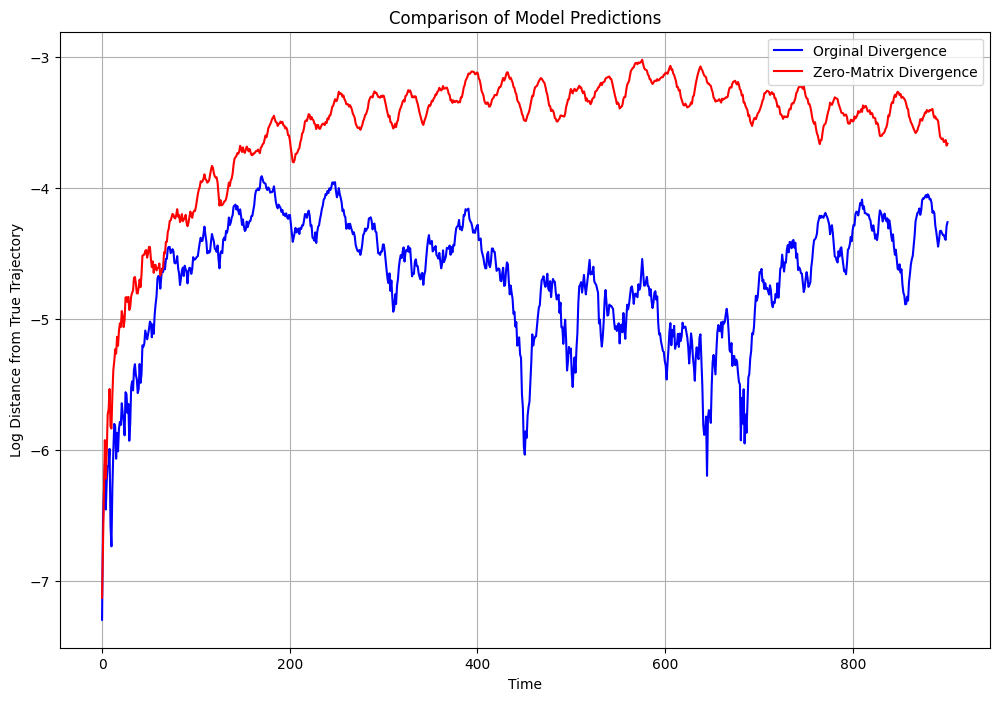


Comparison of Reservoirs:
Original Reservoir divergence rate: 0.0001
Zero-Matrix Reservoir divergence rate: 0.0012

Mean Absolute Error:
Original Reservoir: 0.0102
Zero-Matrix Reservoir: 0.0314


In [6]:

# Compare the predictions
slope1, slope2, divs1, divs2, times = compare_predictions(
    actual_data=test_data,
    predicted_data1=predictions,
    predicted_data2=predictions_2,
    t_span=(0, len(test_data))
)

print("\nComparison of Reservoirs:")
print(f"Original Reservoir divergence rate: {slope1:.4f}")
print(f"Zero-Matrix Reservoir divergence rate: {slope2:.4f}")


# Calculate MAE for both models
mae1 = np.mean(np.exp(divs1))
mae2 = np.mean(np.exp(divs2))

print(f"\nMean Absolute Error:")
print(f"Original Reservoir: {mae1:.4f}")
print(f"Zero-Matrix Reservoir: {mae2:.4f}")


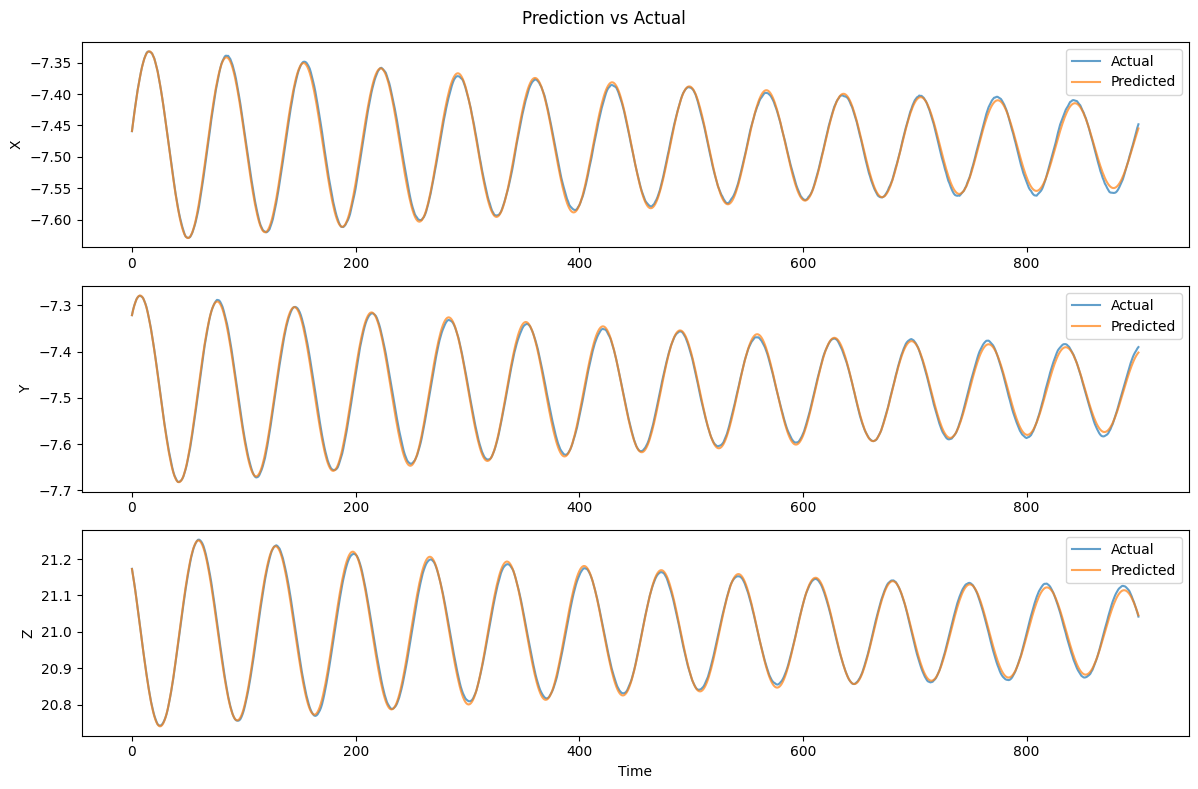

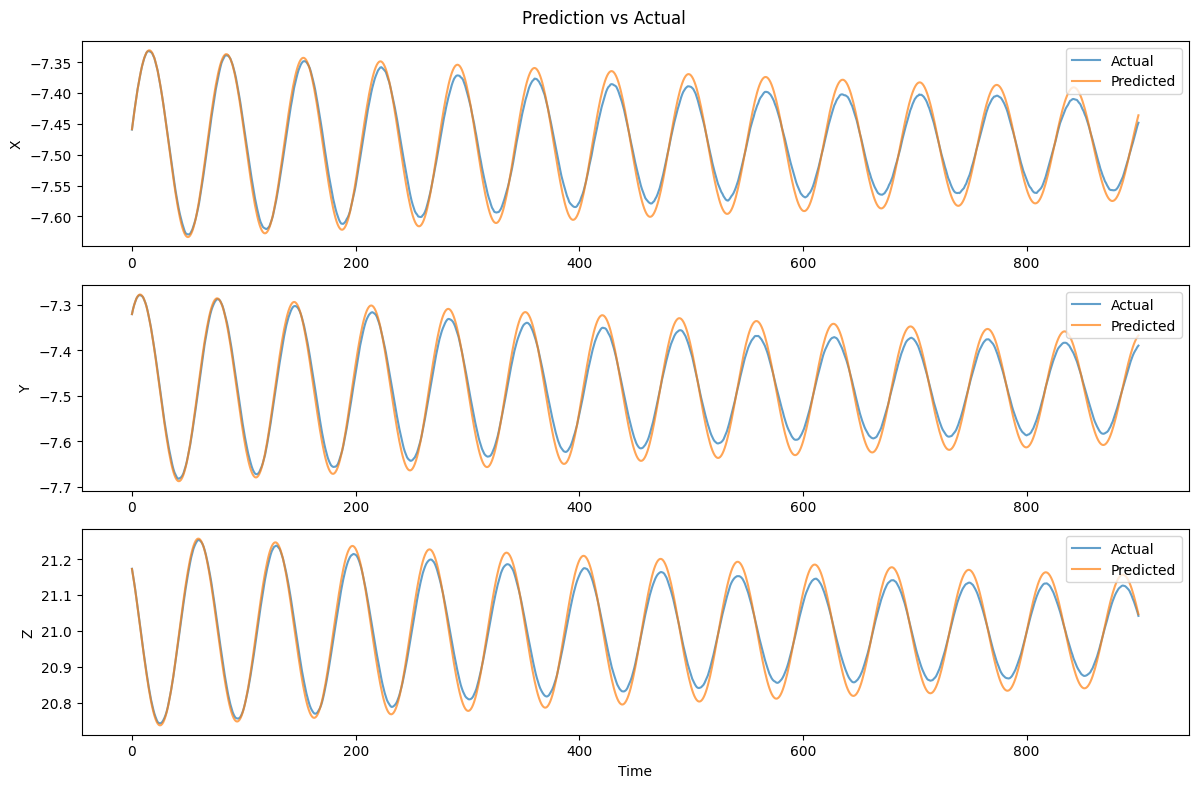

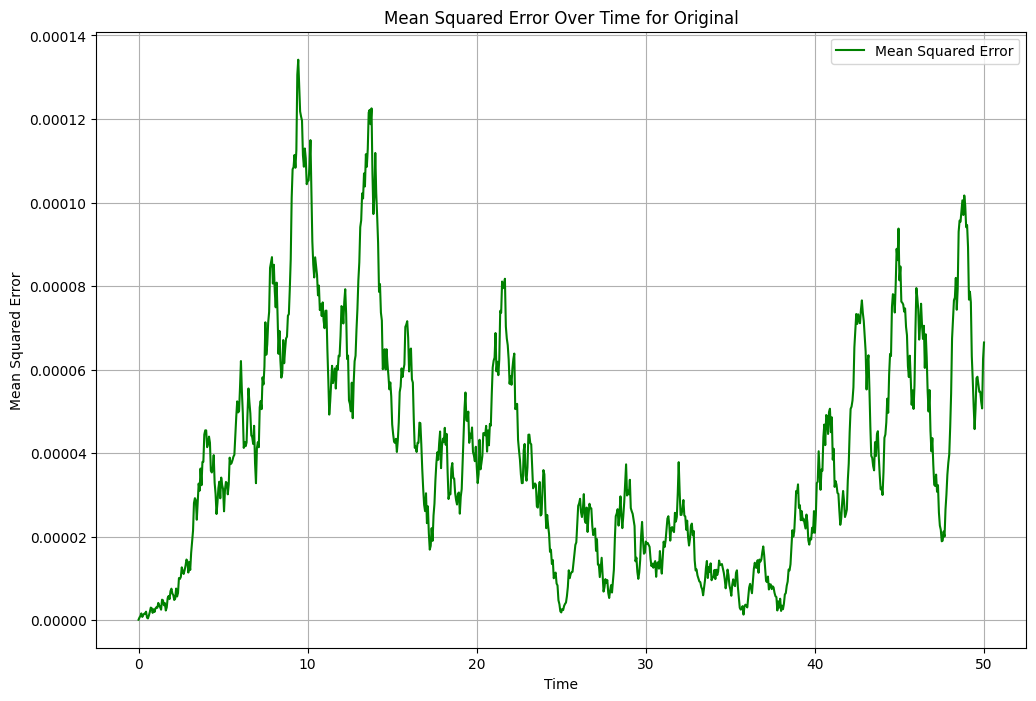

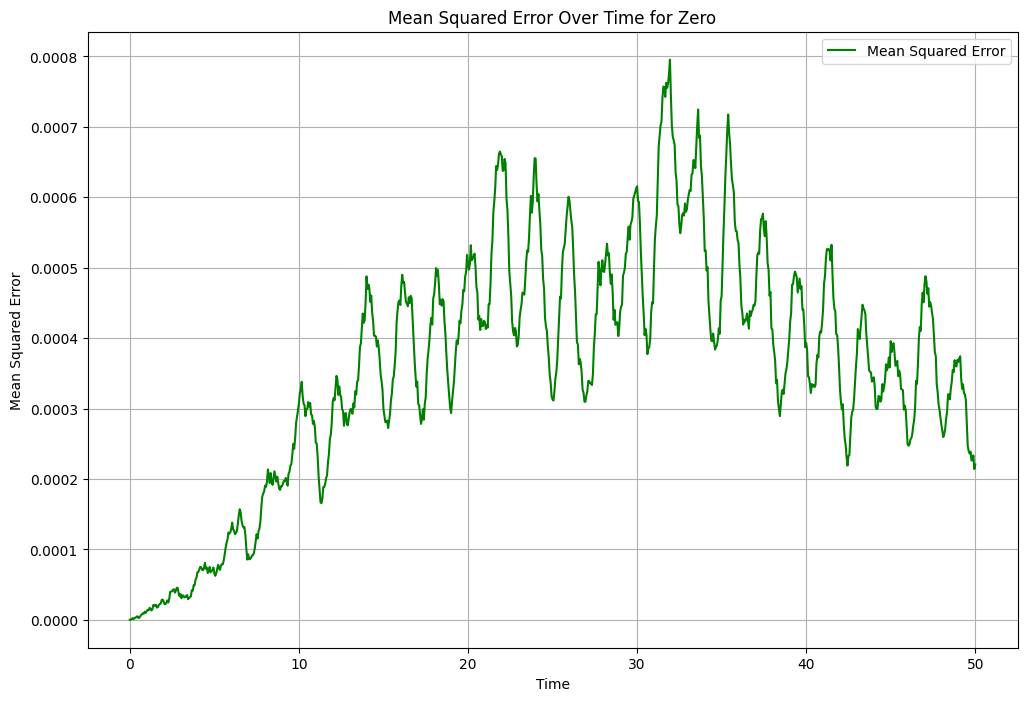

MSE: [[1.07911881e-07 2.92730356e-09 3.48119536e-07]
 [3.47897026e-07 8.53840272e-07 8.54960657e-07]
 [1.07892411e-06 2.45325764e-07 1.84216956e-06]
 [1.37617953e-07 5.08662624e-08 4.79364314e-06]
 [2.72244824e-07 1.66343188e-07 2.03574472e-06]
 [1.91381973e-06 7.14128357e-08 1.84024847e-06]
 [8.53150566e-08 3.25638803e-07 4.38479351e-06]
 [1.95977089e-07 3.42209966e-07 4.32160872e-06]
 [8.78720684e-09 1.44565602e-06 4.78628396e-06]
 [1.50980615e-07 2.25418658e-07 1.57046829e-06]]
MIN MSE: 4.909248124737498e-12
MAX MSE: 7.509562885465103e-06
MSE: [[2.44886704e-07 7.30160252e-08 3.23987944e-07]
 [1.15724063e-07 3.26732928e-07 1.03636440e-06]
 [5.44492288e-07 1.24648781e-08 2.61830425e-06]
 [4.91481072e-10 4.62679349e-07 6.67223301e-06]
 [7.80061573e-09 9.00544847e-09 3.94661444e-06]
 [7.52804123e-07 6.82657123e-07 4.48154470e-06]
 [8.39050923e-08 1.28590948e-06 9.17302183e-06]
 [3.99334363e-08 1.32262854e-06 1.00413564e-05]
 [4.04399810e-07 3.13891037e-06 1.20428590e-05]
 [1.82202947e-0

In [7]:

# Visualize results
plot_prediction_comparison(test_data, predictions) 
plot_prediction_comparison(test_data, predictions_2)

# Plotting MSE over time
plot_mse(test_data, predictions, "Original", t_span)
plot_mse(test_data, predictions_2, "Zero", t_span)

print(f"MSE: {(mse_per_timestep:=((predictions - test_data) ** 2)[:10])}")
print(f"MIN MSE: {np.min(((predictions - test_data) ** 2)[:20])}")
print(f"MAX MSE: {np.max(((predictions - test_data) ** 2)[:20])}")
print(f"MSE: {((predictions_2 - test_data) ** 2)[:10]}")

# Find first point where MSE exceeds threshold
divergence_points = np.where(mse_per_timestep > 10)[0]

if len(divergence_points) == 0:
    print("never diverged")  # Never diverged
else:
    print(divergence_points[0])  # Return first divergence point

### Hyperparameter Testing

In [2]:
# Generate data
x0 = [1,1,1]

t_end = 500
t_eval = .1
t_span = (0,t_end)

train_test_split = .9

data = solve_lorenz(t_end=t_end, t_eval=t_eval, initial_state=x0)
# Split data
split_idx = int((t_end/t_eval)*train_test_split)
train_data = data[:split_idx]
test_data = data[split_idx:]
print(split_idx)

4500


In [3]:
param_grid = {
    'edge_prob': [.1, .2, .3],
    'graph_type': ["default","zero"],
    'reservoir_dim': [300, 500, 1000],
    'spectral_radius': [1, 1.2, 1.4],
    'beta': [.5, 1, 1.5]
}

In [ ]:
# # One Time Step Error Hyp Search
# best_params, best_score, all_results = grid_search_OTSE(
#     train_data=train_data,
#     test_data=test_data,
#     param_grid=param_grid,
# )

In [4]:
# General Hyp Search
best_params, best_score, final_result, pred_horizon, all_results = grid_search_tuning(
    train_data=train_data,
    test_data=test_data,
    param_grid=param_grid,
    model_func=run_model_func,
    scoring_func=mse_scoring_func,
)

Testing parameters: {'edge_prob': 0.1, 'graph_type': 'default', 'reservoir_dim': 300, 'spectral_radius': 1, 'beta': 0.5}
first 10 MSE: [[3.31824029e-06 5.08687012e-05 1.44888890e-04]
 [2.91415297e-05 2.17575810e-04 1.99954487e-04]
 [1.53735675e-04 1.85978567e-04 1.01675834e-03]
 [3.81417096e-04 2.99118254e-04 2.78990419e-03]
 [9.44721709e-04 3.22414518e-03 3.12593230e-03]
 [4.47216417e-03 1.90939176e-02 4.18909204e-04]
 [3.02974286e-02 1.11882064e-01 2.02257633e-02]
 [1.05496556e-01 9.15216910e-02 5.10773999e-01]
 [1.36710107e-02 9.64204519e-01 2.15127469e-01]
 [1.33738455e-01 6.84023908e-04 2.88025059e-01]
 [1.19279539e-03 2.78187508e-02 1.40599791e-01]
 [5.30004347e-03 1.74063800e-02 8.54624988e-02]
 [7.44751597e-03 1.25220837e-02 8.71202972e-02]
 [1.76162275e-03 5.69985230e-03 1.00950897e-01]
 [1.12500049e-02 6.76937796e-02 1.10168627e-02]
 [1.85083955e-02 1.50613152e-04 4.47312138e-02]
 [1.91231884e-03 6.47227527e-02 1.12712213e-02]
 [3.22069687e-02 7.89880265e-02 1.16615553e-03]
 

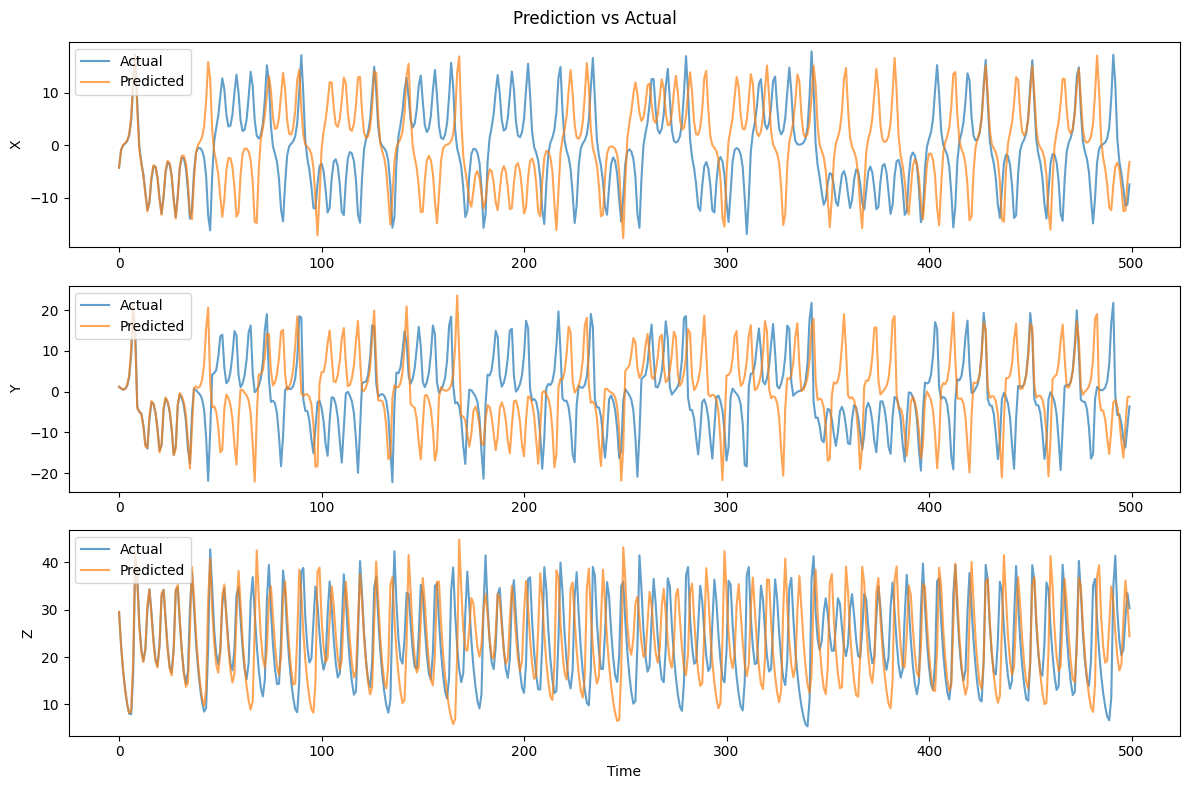

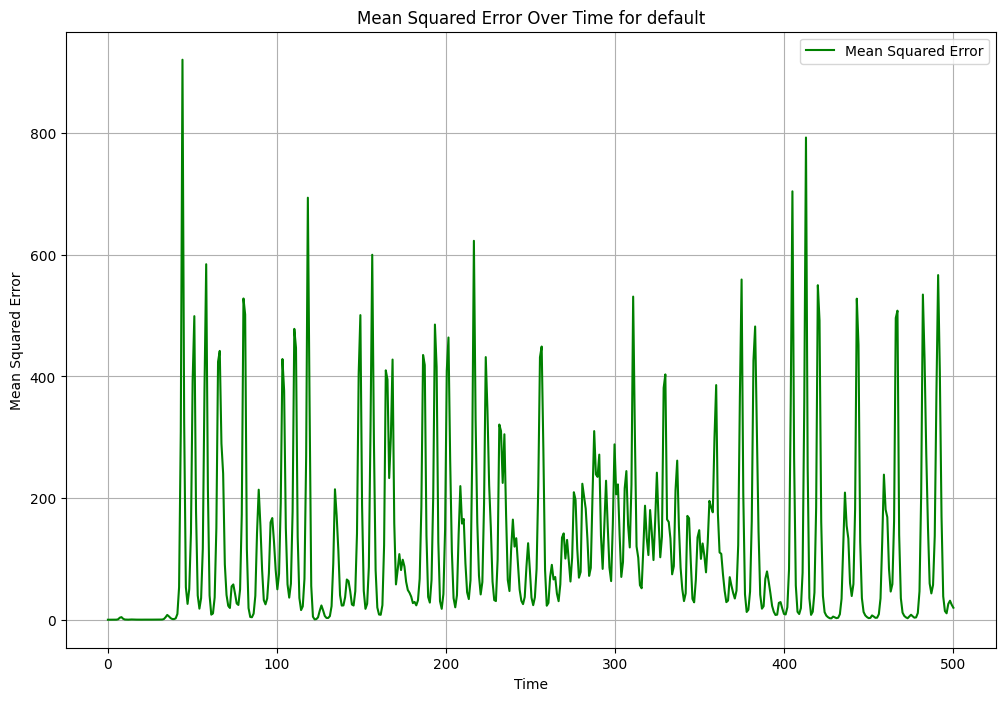

In [5]:
plot_prediction_comparison(test_data, final_result['predictions'])
plot_mse(test_data, final_result['predictions'], f"{best_params['graph_type']}", t_span)

In [6]:
one_step_preds, otse = compute_one_step_error(train_data, test_data, **best_params)

Text(0.5, 1.0, 'One Time Step MSE Error vs Time Step')

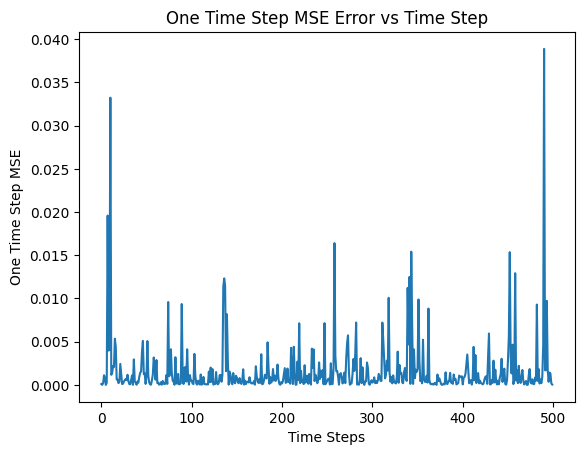

In [10]:
plt.plot(otse)
plt.ylabel("One Time Step MSE")
plt.xlabel("Time Steps")
plt.title("One Time Step MSE Error vs Time Step for Best Parameters")

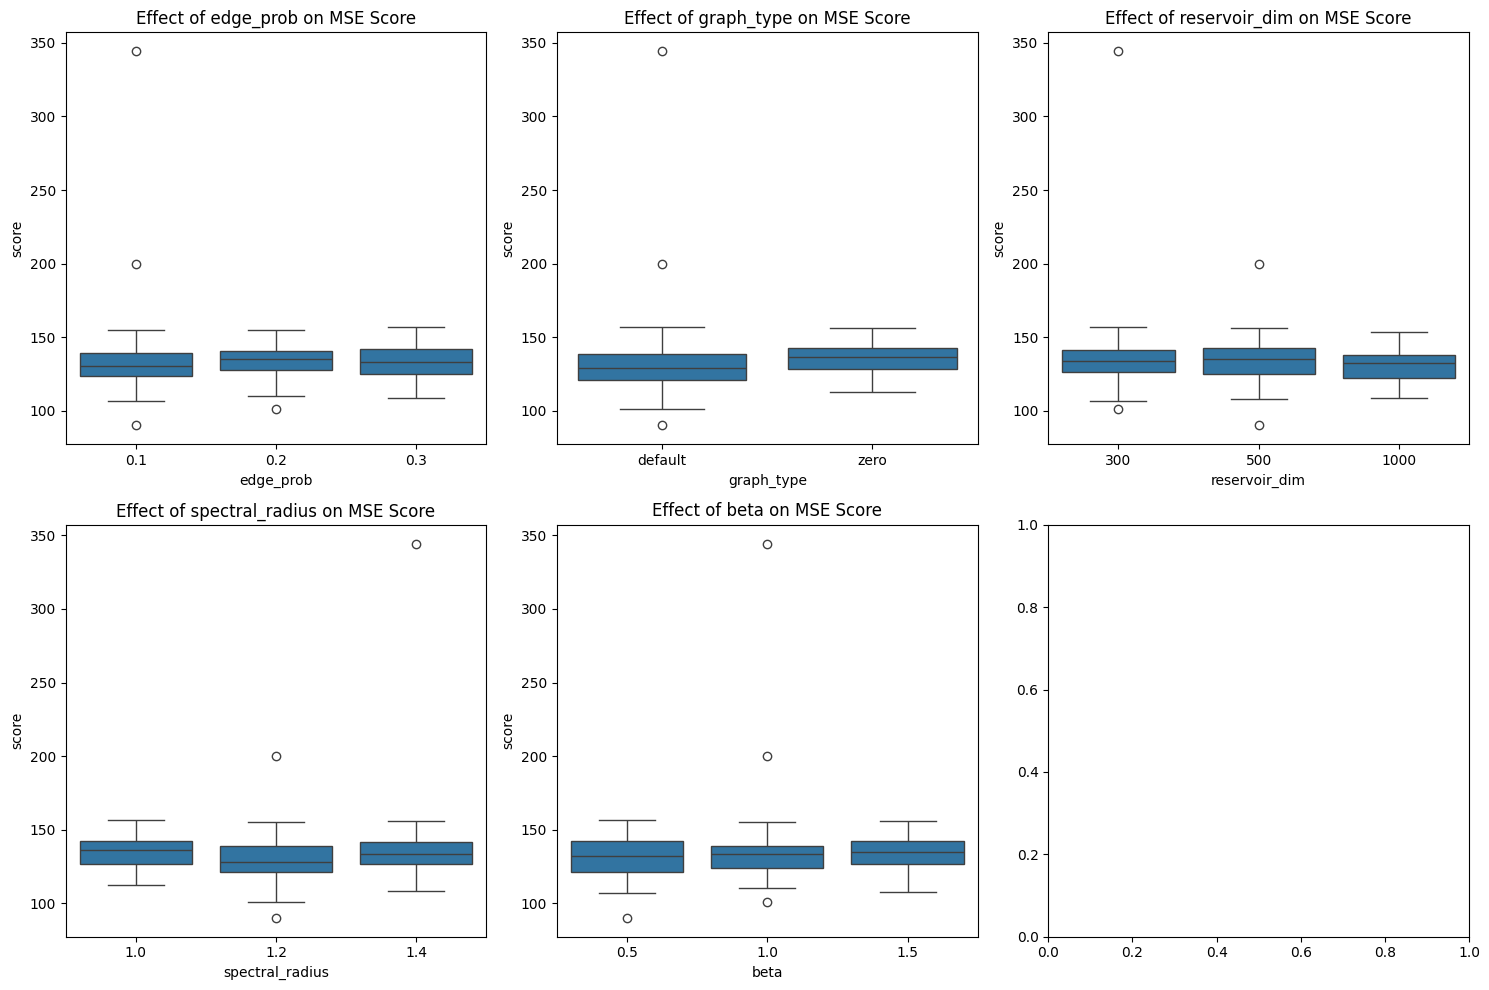

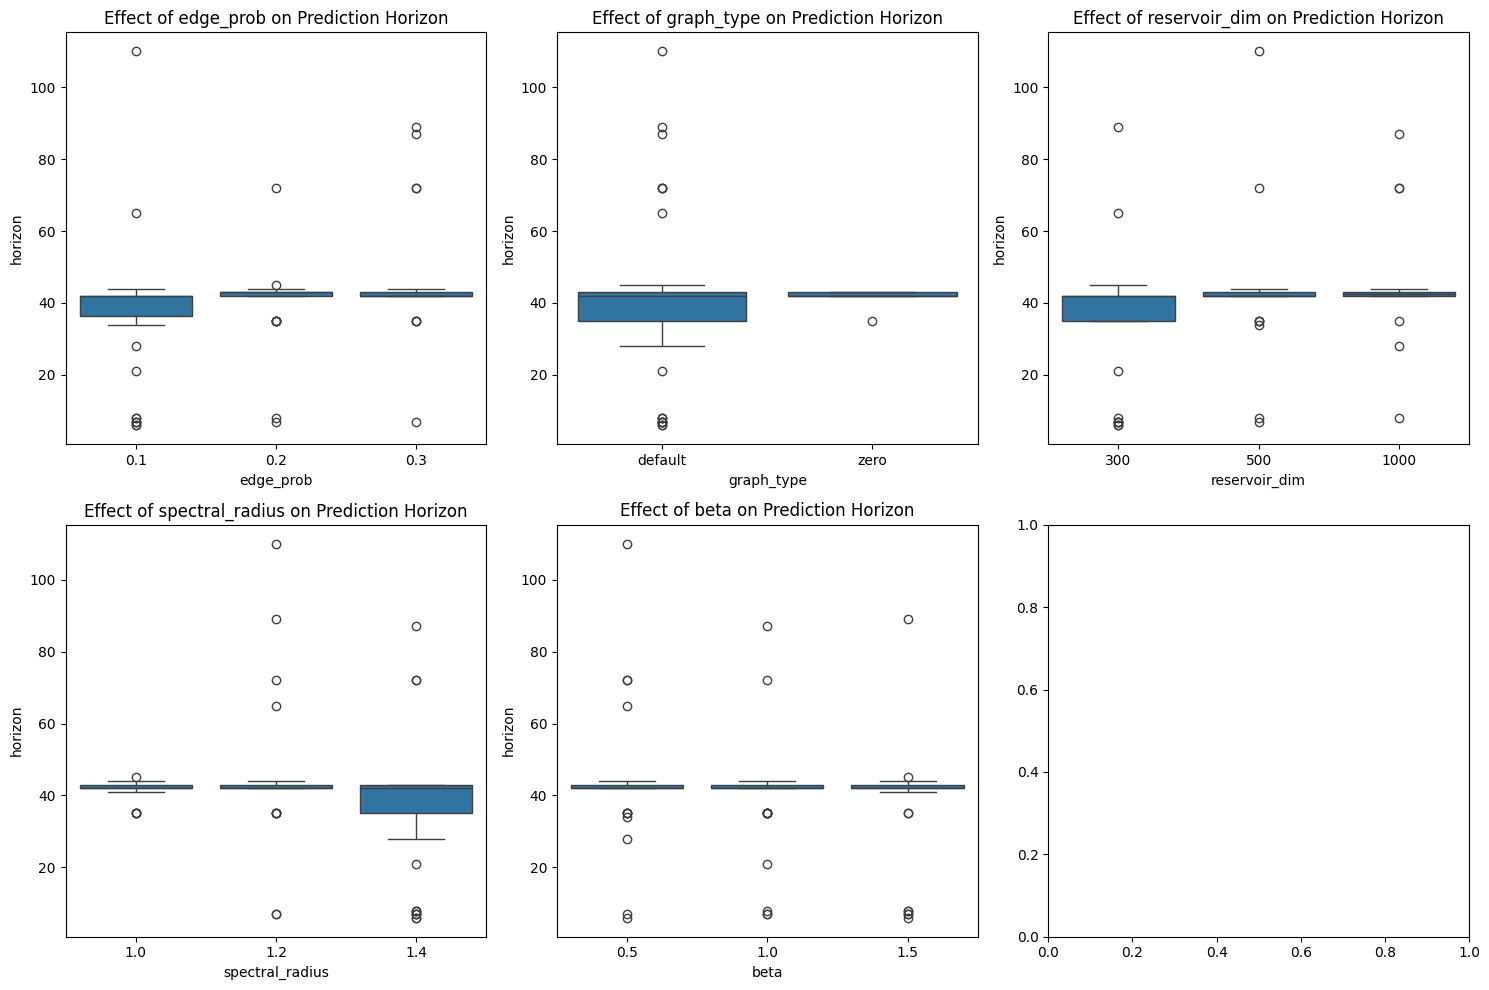


Top 5 parameter combinations by prediction horizon:
     edge_prob graph_type  reservoir_dim  spectral_radius  beta  horizon  \
7          0.1    default            300              1.4   1.0       21   
13         0.1    default            500              1.2   1.0       35   
108        0.3    default            300              1.0   0.5       42   
152        0.3       zero            500              1.4   1.5       42   
31         0.1       zero            300              1.2   1.0       42   

          score  
7    344.481992  
13   199.810473  
108  156.763749  
152  155.957497  
31   155.140436  


In [11]:
# Analyze results
def analyze_parameter_effects(all_results):
    """Analyze how different parameters affect prediction horizon"""
    results_df = pd.DataFrame([
        {**result['params'], 
         'horizon': result['horizon'], 
         'score': result['score']}
        for result in all_results.values()
    ])
    
    # Plot parameter effects
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, param in enumerate(param_grid.keys()):
        if i < len(axes):
            sns.boxplot(data=results_df, x=param, y='score', ax=axes[i])
            axes[i].set_title(f'Effect of {param} on MSE Score')
    
    plt.tight_layout()
    plt.show()

    # Plot parameter effects
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, param in enumerate(param_grid.keys()):
        if i < len(axes):
            sns.boxplot(data=results_df, x=param, y='horizon', ax=axes[i])
            axes[i].set_title(f'Effect of {param} on Prediction Horizon')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Analyze results
results_df = analyze_parameter_effects(all_results)

# Print top 5 parameter combinations
print("\nTop 5 parameter combinations by prediction horizon:")
print(results_df.sort_values('score', ascending=False).head())

### Basins of Attractions

In [ ]:
def fixed_point_analysis():
    sigma = 10
    rho = 22
    beta = 8 / 3

    # Define fixed points for the Lorenz system
    fixed_points = [
        (np.sqrt(beta * (rho - 1)), np.sqrt(beta * (rho - 1)), rho - 1),
        (-np.sqrt(beta * (rho - 1)), -np.sqrt(beta * (rho - 1)), rho - 1)
    ]
    
    # Define ranges for initial conditions
    u_min, u_max, u_step = 0, 1, .05
    v_min, v_max, v_step = 0, 1, .05

    # Create arrays for u and v
    u = np.arange(u_min, u_max, u_step)
    v = np.arange(v_min, v_max, v_step)

    # Generate initial conditions based on fixed points
    initial_conditions_f = [[u[i]*fixed_points[0][0] + v[j]*fixed_points[1][0],
            u[i]*fixed_points[0][1] + v[j]*fixed_points[1][1],
            u[i]*fixed_points[0][2] + v[j]*fixed_points[1][2]] for i in range(len(u)) for j in range(len(v))]
    
    initial_conditions = initial_conditions_f

    # Solve for all initial conditions and classify trajectories
    trajectories = []
    classifications = []
    threshold = 1  # Distance threshold for classification

    for init in initial_conditions:
        # Solve the Lorenz system for the initial condition
        sol = solve_lorenz(initial_state=init, sigma=sigma, beta=beta, rho=rho)
        final_state = sol[-1]

        # Classify the final state based on proximity to fixed points
        if np.linalg.norm(final_state - np.array(fixed_points[0])) < threshold:
            classification = "Fixed Point #1"
        elif np.linalg.norm(final_state - np.array(fixed_points[1])) < threshold:
            classification = "Fixed Point #2"
        else:
            classification = "Butterfly Attractor"

        trajectories.append(sol)
        classifications.append(classification)

    # Plot the initial conditions with classifications
    for init, classification in zip(initial_conditions, classifications):
        # Assign colors based on classification
        if classification == "Fixed Point #1": color = 'r'
        elif classification == "Fixed Point #2": color = 'g'
        else: color = 'black'

        plt.plot(init[1], init[2], marker='o', markersize=5, color=color)